# Klasyfikacja binarna obecności osób w pomieszczeniu na podstawie danych sensorowych (Room Occupancy Estimation) #

* Michał Adamiec 217633
* Piotr Lewandowski 217357

### **Streszczenie**
Celem projektu jest opracowaneie modelu klasyfikacyjnego umożliwiającego wykrycie osób w pomieszczeniu na podstawie danych wielu nieinwazyjnych czujników środowiskowych, takich jak temperatura, światło, dźwięk, CO2 oraz PIR (pasywny czujnik podczerwieni). Zmienna docelowa została przekształcona do postaci binarnej, co pozwala na rozróżnienie sytuacji, gdy pomieszczenie jest puste lub zajęte.

### **Słowa kluczowe**
- klasyfikacja binarna
- analiza danych
- czujniki środowiskowe
- obecność w pomieszczeniu
- uczenie maszynowe

### **Wprowadzenie**
Projekt dotyczy wykrywania obecności osób w pomieszczeniu na podstawie danych z czujników środowiskowych.

### **Przedmiot badania**
Analizujemy dane zebrane w pomieszczeniu wyposażonym w 7 czujników, rejestrujących parametry środowiskowe co 30 sekund.

### **Cel projketu**
Celem jest stworzenie modelu klasyfikacyjnego, który na podstawie danych z czujników przewidzi obecność osób w pomieszczeniu (klasyfikacja binarna).

### **Wstępna analiza danych**

**Charakterystyka zbioru danych**
- Liczba obserwacji: 10129  
- Liczba cech: 18  
- Typ cech: numeryczne (real)

**Przedstawienie dostępnych zmiennych**
* **Date** - data pomiaru w formacie YYYY/MM/DD
* **Time** - godzina pomiaru w formacie HH:MM:SS
* **S1_Temp, S2_Temp, S3_Temp, S4_Temp** - temperatura z czujników S1-S4 (w stopniach Celsjusza)
* **S1_Light, S2_Light, S3_Light, S4_Light** - natężenie światła z czujników S1-S4 (w luksach)
* **S1_Sound, S2_Sound, S3_Sound, S4_Sound** - poziom dźwięku z czujników S1-S4 (w woltach, odczyt z ADC)
* **S5_CO2** - stężenie CO2 z czujnika S5 (w PPM)
* **S5_CO2_Slope** - nachylenie zmian CO2 w oknie czasowym
* **S6_PIR** - detekcja ruchu przez czujnik PIR S6
  * *0* - brak ruchu
  * *1* - wykryto ruch
* **S7_PIR** - detekcja ruchu przez czujnik PIR S7
  * *0* - brak ruchu
  * *1* - wykryto ruch
* **Room_Occupancy_Count** - liczba osób w pomiesczeniu (zmienna docelowa)
  * *0* - pomiesczenie puste
  * *1, 2, 3* - liczba obecnych osób

### Jeśli nie ma odpowiednich pakietów

In [90]:
%pip install scikit-learn ucimlrepo seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importy

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# function that fetches dataset from ucimlrepo
from ucimlrepo import fetch_ucirepo
#Data manipulation
from sklearn.model_selection import train_test_split
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
# KNN importy
from sklearn.neighbors import KNeighborsClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve


### Pobranie zbioru danych i informacje o zmiennych

In [170]:
# fetch dataset 
room_occupancy_estimation = fetch_ucirepo(id=864) 
  
# data (as pandas dataframes) 
X = room_occupancy_estimation.data.features 
y = room_occupancy_estimation.data.targets 

# metadata 
print(room_occupancy_estimation.metadata) 
  
# variable information 
print(room_occupancy_estimation.variables) 


{'uci_id': 864, 'name': 'Room Occupancy Estimation', 'repository_url': 'https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation', 'data_url': 'https://archive.ics.uci.edu/static/public/864/data.csv', 'abstract': 'Data set for estimating the precise number of occupants in a room using multiple non-intrusive environmental sensors like temperature, light, sound, CO2 and PIR.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 10129, 'num_features': 18, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Room_Occupancy_Count'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Wed Aug 16 2023', 'dataset_doi': '10.24432/C5P605', 'creators': ['Adarsh Pal Singh', 'Sachin Chaudhari'], 'intro_paper': {'ID': 275, 'type': 'NATIVE', 'title': 'Machine Learning-Based Occupancy Estimation Using Multivariate Sensor Nodes', 'auth

### Podgląd danych

In [171]:
X.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0


In [172]:
y.head()

,Room_Occupancy_Count
0,1
1,1
2,1
3,1
4,1


### Pierwsze wystąpienia dla każdej wartości Room_Occupancy_Count

In [173]:
unique_values = y['Room_Occupancy_Count'].unique()
indices = [y[y['Room_Occupancy_Count'] == val].index[0] for val in unique_values]
display(X.loc[indices])

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
75,2017/12/22,11:28:29,25.38,25.44,24.81,25.69,150,187,63,49,0.46,0.46,0.21,0.11,450,1.088462,1,1
191,2017/12/22,12:30:16,25.69,28.44,25.19,26.00,156,244,190,64,1.12,0.49,0.77,0.25,645,0.411538,1,1
346,2017/12/22,14:15:58,26.19,27.25,26.13,26.44,19,22,97,60,0.42,3.03,3.67,0.64,950,-0.069231,1,1


In [174]:
display(y.loc[indices])

,Room_Occupancy_Count
0,1
75,2
191,3
346,0


### Liczba wystąpień każdej zmiennej Room_Occupancy_Count w zbiorze danych

In [175]:
print(y['Room_Occupancy_Count'].value_counts())

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64


## Tworzenie nowych cech

**Nowo utworzone cechy**
* **Temp_mean** – średnia temperatura z czujników S1–S4 (w stopniach Celsjusza)
* **Light_sum** - suma natężenia światła z czterech czujników (w luksach)
* **Sound_mean** - średnia wartość poziomu dźwięku z czterech czujników (w woltach)
* **CO2_to_Sound** - stosunek stężenia CO2 do sumy poziomu dźwięku (bezwymiarowe)
* **PIR_active** - liczba aktywnych czujników ruchu PIR (wartość 0, 1 lub 2)

In [176]:
X['Temp_mean'] = X[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']].mean(axis=1)
X['Light_sum'] = X[['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']].sum(axis=1)
X['Sound_mean'] = X[['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']].mean(axis=1)
X['CO2_to_Sound'] = X['S5_CO2'] / (X[['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']].sum(axis=1) + 1e-6)
X['PIR_active'] = X['S6_PIR'] + X['S7_PIR']

X.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Temp_mean,Light_sum,Sound_mean,CO2_to_Sound,PIR_active
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.06,390,0.769231,0,0,24.9075,248,0.0975,999.997436,0
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.06,390,0.646154,0,0,24.9225,247,0.2750,354.545132,0
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.06,390,0.519231,0,0,24.9225,248,0.1700,573.528568,0
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.09,390,0.388462,0,0,24.9375,248,0.1750,557.142061,0
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,390,0.253846,0,0,24.9375,249,0.0900,1083.330324,0


## Przygotowanie danych do klasyfikacji binarnej

### Binarna zmienna docelowa i wybór cech

In [ ]:
#Klasyfikacja binarna: 0 - pusty pokój, 1 - zajęty pokój (przekształcenie y)
y = y.rename(columns={'Room_Occupancy_Count': 'Occupied'})
y['Occupied'] = (y['Occupied'] > 0).astype(int)
y = y[['Occupied']]
y.head()

#Usunięcie kolumn Date i Time z X
X=X.drop(columns=['Date', 'Time'])

### Pierwsze wystąpienia dla każdej wartości Occupied

In [178]:
unique_values = y['Occupied'].unique()
indices = [y[y['Occupied'] == val].index[0] for val in unique_values]
display(X.loc[indices])

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Temp_mean,Light_sum,Sound_mean,CO2_to_Sound,PIR_active
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,...,0.06,390,0.769231,0,0,24.9075,248,0.0975,999.997436,0
191,25.69,28.44,25.19,26.00,156,244,190,64,1.12,0.49,...,0.25,645,0.411538,1,1,26.3300,654,0.6575,245.247055,2


In [179]:
display(y.loc[indices])

,Occupied
0,0
191,1


### Liczba wystąpień każdej zmiennej Occupied w zbiorze danych

In [180]:
print(y['Occupied'].value_counts())

Occupied
0    9435
1     694
Name: count, dtype: int64


### Podział na zbiory treningowy i walidacyjny (60/40)

Dane zostały podzielone na zbiór treningowy (60%) i walidacyjny (40%), aby rzetelnie ocenić skuteczność modeli na nowych, niewidzianych wcześniej danych.

In [181]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

print("Liczba rekordów w zbiorze treningowym:", len(X_train))
print("Liczba rekordów w zbiorze walidacyjnym:", len(X_val))

Liczba rekordów w zbiorze treningowym: 6077
Liczba rekordów w zbiorze walidacyjnym: 4052


## Metody klasyfikacji danych

### <mark>Drzewo decyzyjne</mark> ###
Drzewo decyzyjne to narzędzie, wspierające proces podejmowania decyzji. Polega na przedstawieniu graficznym różnorodnych opcji i ich możliwych konsekwencji - wizualizacja zwykle przyjmuje postać rozgałęziającego się diagramu, co nawiązuje do struktury drzewa.

In [182]:
# Dopasowanie modelu
dt_model = DecisionTreeClassifier(max_depth=2, random_state=1)
dt_model.fit(X_train, y_train)

# Predykcja na zbiorze walidacyjnym
y_pred_dt = dt_model.predict(X_val)
y_proba_dt = dt_model.predict_proba(X_val)[:, 1]

print(y_pred_dt)
print(y_proba_dt)

[0 0 0 ... 0 0 0]
[0.01003944 0.01003944 0.01003944 ... 0.01003944 0.01003944 0.01003944]


### Macierze pomyłek i współczynniki jakości klasyfikacji ###

Klasyfikacja negatywna oznacza niewystępowanie zjawiska (wartość 0 - pokój pusty "No"), natomiast klasyfikacja pozytywna oznacza wystąpienie zjawiska (wartość 1 - pokój zajęty "Yes").
Wyjaśnienie oznaczeń:
* $TN$ - prawidłowa klasyfikacja negatywna
* $TP$ - prawidłowa klasyfikacja pozytywna
* $FP$ - faŁszywa klasyfikacja poztywna
* $FN$ - fałszywa klasyfikacja negatywna  
$TN + TP + FP + FN = $ ilość rekordów testowych

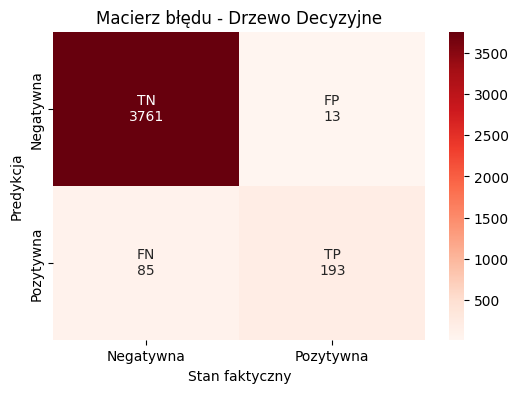

In [183]:
# Macierz pomyłek
cm_dt = confusion_matrix(y_val, y_pred_dt)
dt_tn, dt_fp, dt_fn, dt_tp = cm_dt.ravel()

# Dane i etykiety do wizualizacji
confusion_matrix_data = [
    [dt_tn, dt_fp],
    [dt_fn, dt_tp]
]
confusion_matrix_labels = [
    [f"TN\n{dt_tn}", f"FP\n{dt_fp}"],
    [f"FN\n{dt_fn}", f"TP\n{dt_tp}"]
]

plt.figure(figsize=(6, 4))
ax = sns.heatmap(confusion_matrix_data, annot=confusion_matrix_labels, fmt="", cmap="Reds",
            xticklabels=["Negatywna", "Pozytywna"],
            yticklabels=["Negatywna", "Pozytywna"])
plt.title("Macierz błędu - Drzewo Decyzyjne")
plt.xlabel("Stan faktyczny")
plt.ylabel("Predykcja")
plt.show()

### Współczynniki wydajności klasyfikacji ###
**Trafność** (Accuracy) - odsetek poprawnych, prawidłowych klasyfikacji dokonywanych przez model  

$ \frac{TP+TN}{TP+TN+FP+FN}$

**Czułość** (Recall) - zdolność modelu do wykrywania rzeczywistych pozytywnych przykładów

$\frac{TP}{TP+FN}$

**Specyficzność** (Specificity) – zdolność modelu do prawidłowego wykrywania przykładów negatywnych (czyli poprawnego rozpoznania klasy 0, np. pustego pokoju)

$\frac{TN}{TN+FP}$

**AUC** (Area Under the Curve) - to miara używana do oceny wydajności modelu klasyfikacji binarnej na podstawie krzywej ROC.

In [184]:
accuracy_dt = accuracy_score(y_val, y_pred_dt)
recall_dt = recall_score(y_val, y_pred_dt)
specifity_dt = recall_score(y_val, y_pred_dt, pos_label=0)
auc_dt = roc_auc_score(y_val, y_proba_dt)

print("Accuracy modelu drzewa decyzyjnego:", accuracy_dt)
print("Recall modelu drzewa decyzyjnego:", recall_dt)
print("Specifity modelu drzewa decyzyjnego:", specifity_dt)
print("AUC modelu drzewa decyzyjnego:", auc_dt)

Accuracy modelu drzewa decyzyjnego: 0.9758144126357354
Recall modelu drzewa decyzyjnego: 0.6942446043165468
Specifity modelu drzewa decyzyjnego: 0.9965553789083201
AUC modelu drzewa decyzyjnego: 0.9183332189574255


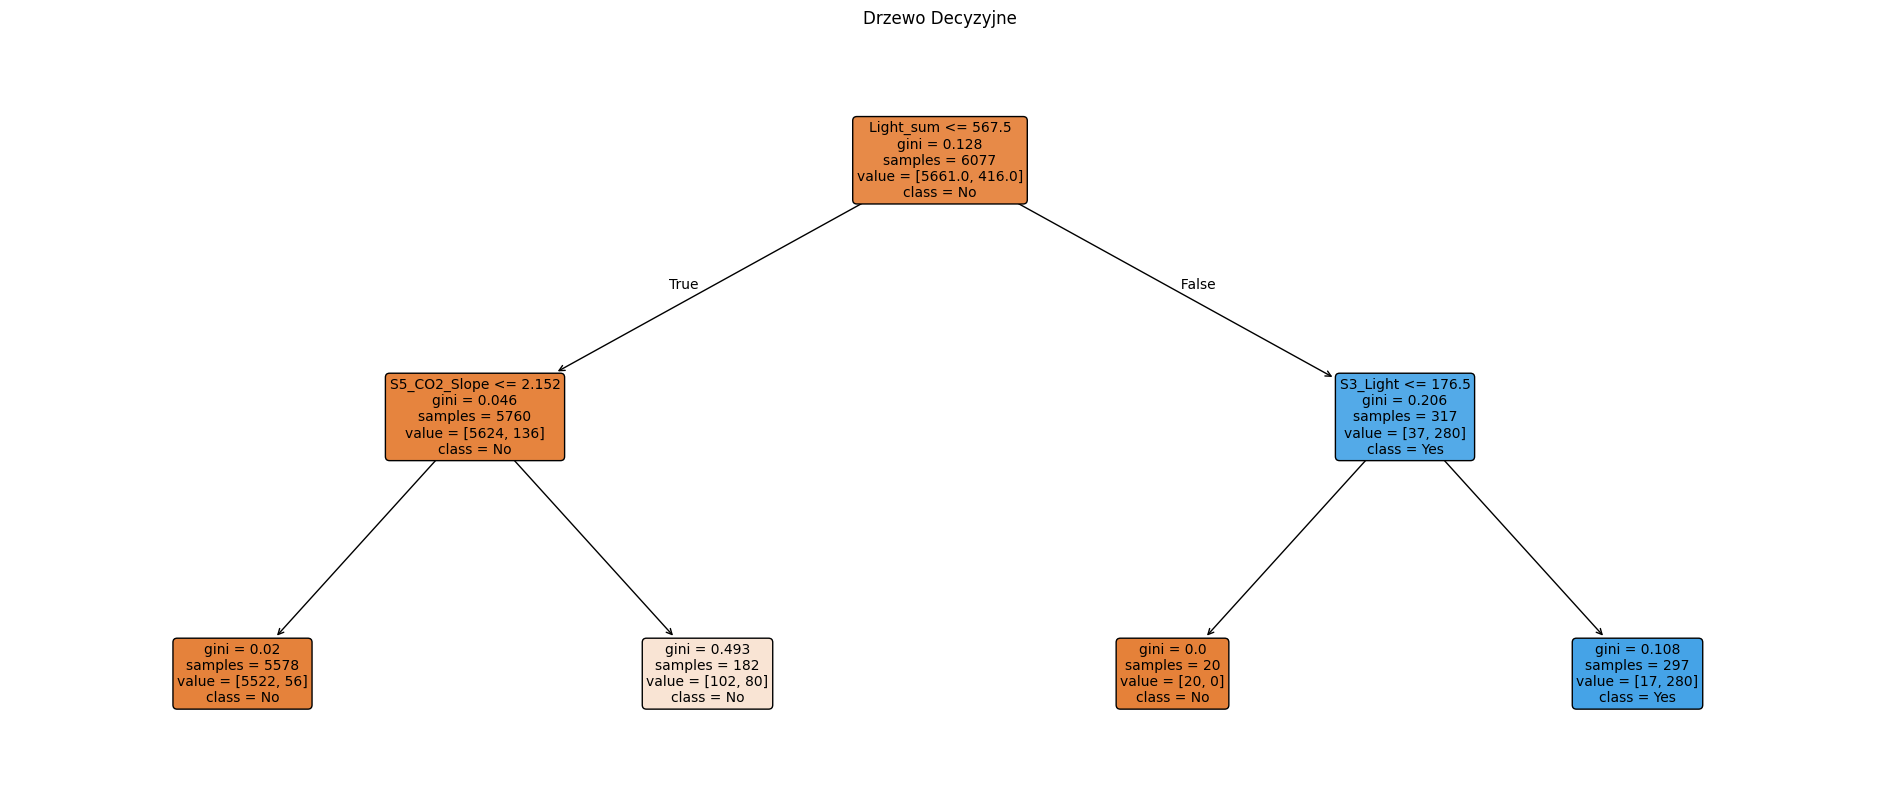

In [185]:
plt.figure(figsize=(24, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['No', 'Yes'], rounded=True, fontsize=10)
plt.title("Drzewo Decyzyjne")
plt.show()

### <mark>KNN - algorytm najbliższego sąsiada</mark> ###
To jeden z najbardziej podstawowych, ale niezbędnych algorytmów klasyfikacyjnych w uczeniu maszynowym. Należy do domeny uczenia się nadzorowanego i znajduje szerokie zastosowanie w rozpoznawaniu wzorców, eksploracji danych i wykrywaniu włamań.

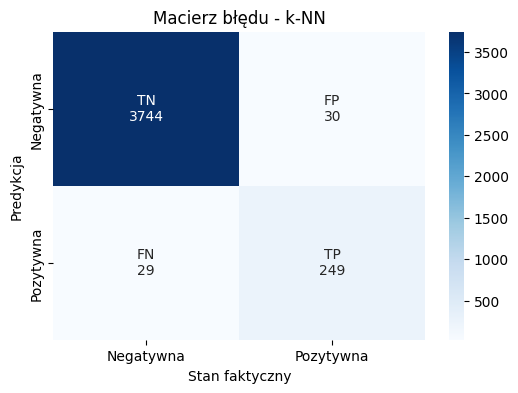

In [186]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

# Stworzenie i dopasowanie modelu 48-NN
knn_model = KNeighborsClassifier(n_neighbors=20, weights='uniform', algorithm='auto')
knn_model.fit(X_train_scaled, y_train.values.ravel())

# Dokonaj predykcji na danych testowych
y_pred_knn = knn_model.predict(X_val_scaled)
y_proba_knn = knn_model.predict_proba(X_val_scaled)[:, 1]

# Klasyfikator 1-NN
knn_cm = confusion_matrix(y_val, y_pred_knn)
knn_tn, knn_fp, knn_fn, knn_tp = knn_cm.ravel()

# Macierz pomyłek
confusion_matrix_data = [
    [knn_tn, knn_fp],
    [knn_fn, knn_tp]
]

# Etykiety dla macierzy pomyłek
confusion_matrix_labels = [
    [f"TN\n{knn_tn}", f"FP\n{knn_fp}"],
    [f"FN\n{knn_fn}", f"TP\n{knn_tp}"]
]

# Rysowanie macierzy pomyłek
plt.figure(figsize=(6, 4))
ax = sns.heatmap(confusion_matrix_data, annot=confusion_matrix_labels, fmt="", cmap="Blues", 
            xticklabels=["Negatywna", "Pozytywna"],
            yticklabels=["Negatywna", "Pozytywna"])

plt.title("Macierz błędu - k-NN")
plt.xlabel("Stan faktyczny")
plt.ylabel("Predykcja")
plt.show()

In [187]:
accuracy_knn = accuracy_score(y_val, y_pred_knn)
recall_knn = recall_score(y_val, y_pred_knn)
specifity_knn = recall_score(y_val, y_pred_knn, pos_label=0)
auc_knn = roc_auc_score(y_val, y_proba_knn)

print("Accuracy modelu k-NN:", accuracy_knn)
print("Recall modelu k-NN:", recall_knn)
print("Specifity modelu k-NN:", specifity_knn)
print("AUC modelu k-NN:", auc_knn)


Accuracy modelu k-NN: 0.9854392892398816
Recall modelu k-NN: 0.89568345323741
Specifity modelu k-NN: 0.9920508744038156
AUC modelu k-NN: 0.9979917496845131


### <mark>Las Losowy (Random Forest)</mark> ###
Las losowy to zaawansowana metoda zespołowa (ang. ensemble method), stanowiąca naturalne rozwinięcie koncepcji pojedynczego drzewa decyzyjnego. Algorytm ten polega na wygenerowaniu dużej liczby drzew decyzyjnych, które uczą się niezależnie od siebie. Ostateczny wynik klasyfikacji ustalany jest na drodze „głosowania” – system wybiera tę decyzję, która została wskazana przez większość drzew w lesie. Dzięki temu podejściu model jest bardziej stabilny i precyzyjny niż pojedyncze drzewo.

### Optymalizacja liczby drzew (`n_estimators`)

Poniższy fragment kodu przeprowadza eksperyment mający na celu dobranie optymalnej liczby drzew w lesie losowym. Zdefiniowano listę wartości od **10 do 1000**, a następnie w pętli trenowano kolejne modele.

**Cel analizy:**
* Znalezienie balansu między jakością modelu a czasem obliczeń.
* Identyfikacja punktu stabilizacji, w którym dodawanie kolejnych drzew przestaje istotnie poprawiać wyniki.

**Metodyka:**
1.  Dla każdej iteracji mierzona jest dokładność klasyfikacji (**accuracy**) na zbiorze walidacyjnym.
2.  Wyniki są wizualizowane na wykresie liniowym, aby ułatwić interpretację.

Drzew: 10 -> Dokładność: 0.9975
Drzew: 30 -> Dokładność: 0.9985
Drzew: 50 -> Dokładność: 0.9980
Drzew: 100 -> Dokładność: 0.9983
Drzew: 150 -> Dokładność: 0.9983
Drzew: 200 -> Dokładność: 0.9983
Drzew: 300 -> Dokładność: 0.9978
Drzew: 1000 -> Dokładność: 0.9980
Najlepszy wynik dla 30 drzew


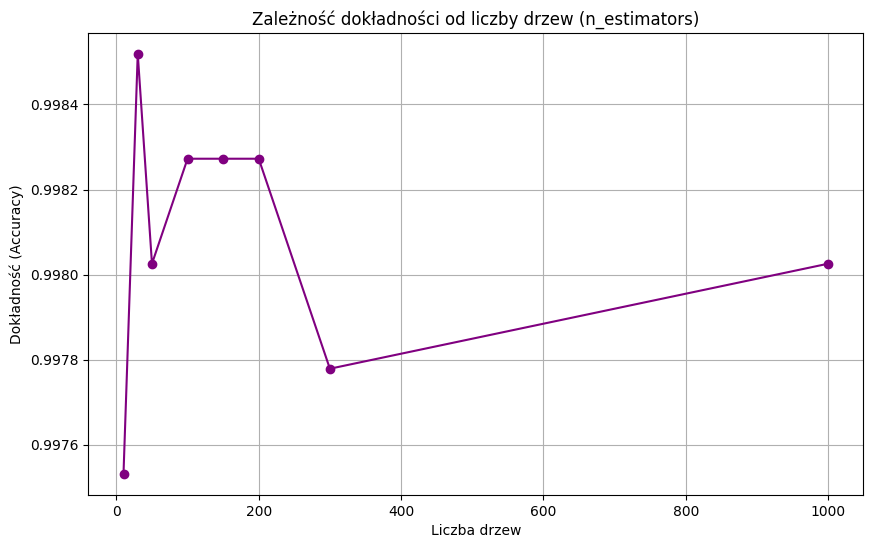

In [219]:
# Lista liczby drzew do sprawdzenia
n_trees_list = [10, 30, 50, 100, 150, 200, 300, 1000]
scores = []

for n in n_trees_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train.values.ravel())

    score = accuracy_score(y_val, rf.predict(X_val))
    scores.append(score)
    print(f"Drzew: {n} -> Dokładność: {score:.4f}")

n_best = n_trees_list[scores.index(max(scores))]
print(f'Najlepszy wynik dla {n_best} drzew')

plt.figure(figsize=(10, 6))
plt.plot(n_trees_list, scores, marker='o', linestyle='-', color='purple')
plt.title('Zależność dokładności od liczby drzew (n_estimators)')
plt.xlabel('Liczba drzew')
plt.ylabel('Dokładność (Accuracy)')
plt.grid(True)
plt.show()

### Trenowanie Finalnego Modelu i Analiza Błędów 

Mając wyznaczoną optymalną liczbę drzew (`n_best`), przechodzimy do etapu **trenowania ostatecznego modelu** oraz szczegółowej oceny jego skuteczności.


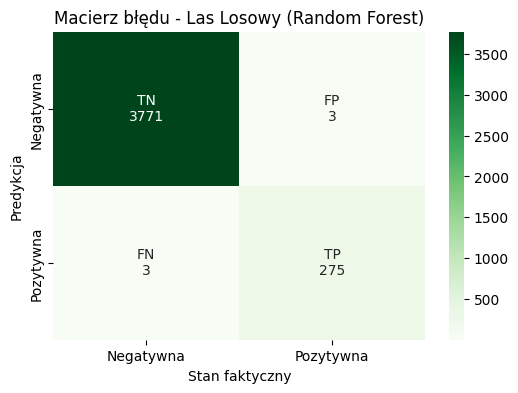

In [220]:
# Stworzenie i dopasowanie modelu Lasu Losowego
# n_estimators to liczba drzew w lesie
rf_model = RandomForestClassifier(n_estimators=n_best, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())

# Dokonaj predykcji na danych walidacyjnych
y_pred_rf = rf_model.predict(X_val)
y_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Obliczanie macierzy pomyłek dla Lasu Losowego
rf_cm = confusion_matrix(y_val, y_pred_rf)
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()

# Macierz pomyłek - dane
confusion_matrix_data_rf = [
    [rf_tn, rf_fp],
    [rf_fn, rf_tp]
]

# Etykiety dla macierzy pomyłek
confusion_matrix_labels_rf = [
    [f"TN\n{rf_tn}", f"FP\n{rf_fp}"],
    [f"FN\n{rf_fn}", f"TP\n{rf_tp}"]
]

# Rysowanie macierzy pomyłek
plt.figure(figsize=(6, 4))
ax = sns.heatmap(confusion_matrix_data_rf, annot=confusion_matrix_labels_rf, fmt="", cmap="Greens", 
            xticklabels=["Negatywna", "Pozytywna"],
            yticklabels=["Negatywna", "Pozytywna"])

plt.title("Macierz błędu - Las Losowy (Random Forest)")
plt.xlabel("Stan faktyczny")
plt.ylabel("Predykcja")
plt.show()

In [221]:
accuracy_rf = accuracy_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
specifity_rf = recall_score(y_val, y_pred_rf, pos_label=0)
auc_rf = roc_auc_score(y_val, y_proba_rf)

print("Accuracy modelu lasu losowego:", accuracy_rf)
print("Recall modelu lasu losowego:", recall_rf)
print("Specifity modelu lasu losowego:", specifity_rf)
print("AUC modelu Lasu losowego:", auc_rf)

Accuracy modelu lasu losowego: 0.9985192497532083
Recall modelu lasu losowego: 0.9892086330935251
Specifity modelu lasu losowego: 0.9992050874403816
AUC modelu Lasu losowego: 0.9999447183112016


### Analiza Ważności Cech 

Jedną z zalet lasów losowych jest wbudowana możliwość oceny, które zmienne (cechy) mają największy wpływ na decyzje modelu.

**Poniższy kod realizuje trzy zadania:**
1.  **Ekstrakcja danych:** Pobiera wartości `feature_importances_` z wytrenowanego modelu. Wartości te określają, jak bardzo dana cecha przyczyniła się do redukcji zanieczyszczenia (np. indeksu Gini) w węzłach drzew.
2.  **Ranking:** Sortuje cechy od najbardziej do najmniej istotnych.
3.  **Wizualizacja:** Generuje poziomy wykres słupkowy, który pozwala na szybką identyfikację kluczowych czynników sterujących predykcją.

> **Interpretacja:** Cechy na górze wykresu są kluczowe dla modelu. Cechy na samym dole, o wartości bliskiej zeru, mogą być potencjalnymi kandydatami do usunięcia w celu uproszczenia modelu.

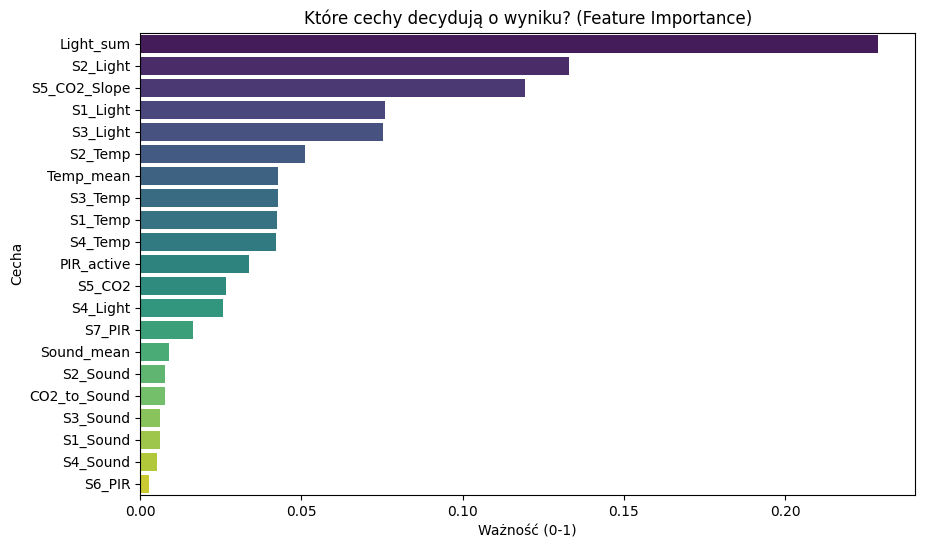

In [222]:
import pandas as pd
# Pobieramy ważność cech z wytrenowanego modelu
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Tworzymy ramkę danych do wykresu
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Rysujemy wykres
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances.values, y=forest_importances.index, palette="viridis", hue=forest_importances.index)

plt.title("Które cechy decydują o wyniku? (Feature Importance)")
plt.xlabel("Ważność (0-1)")
plt.ylabel("Cecha")
plt.show()

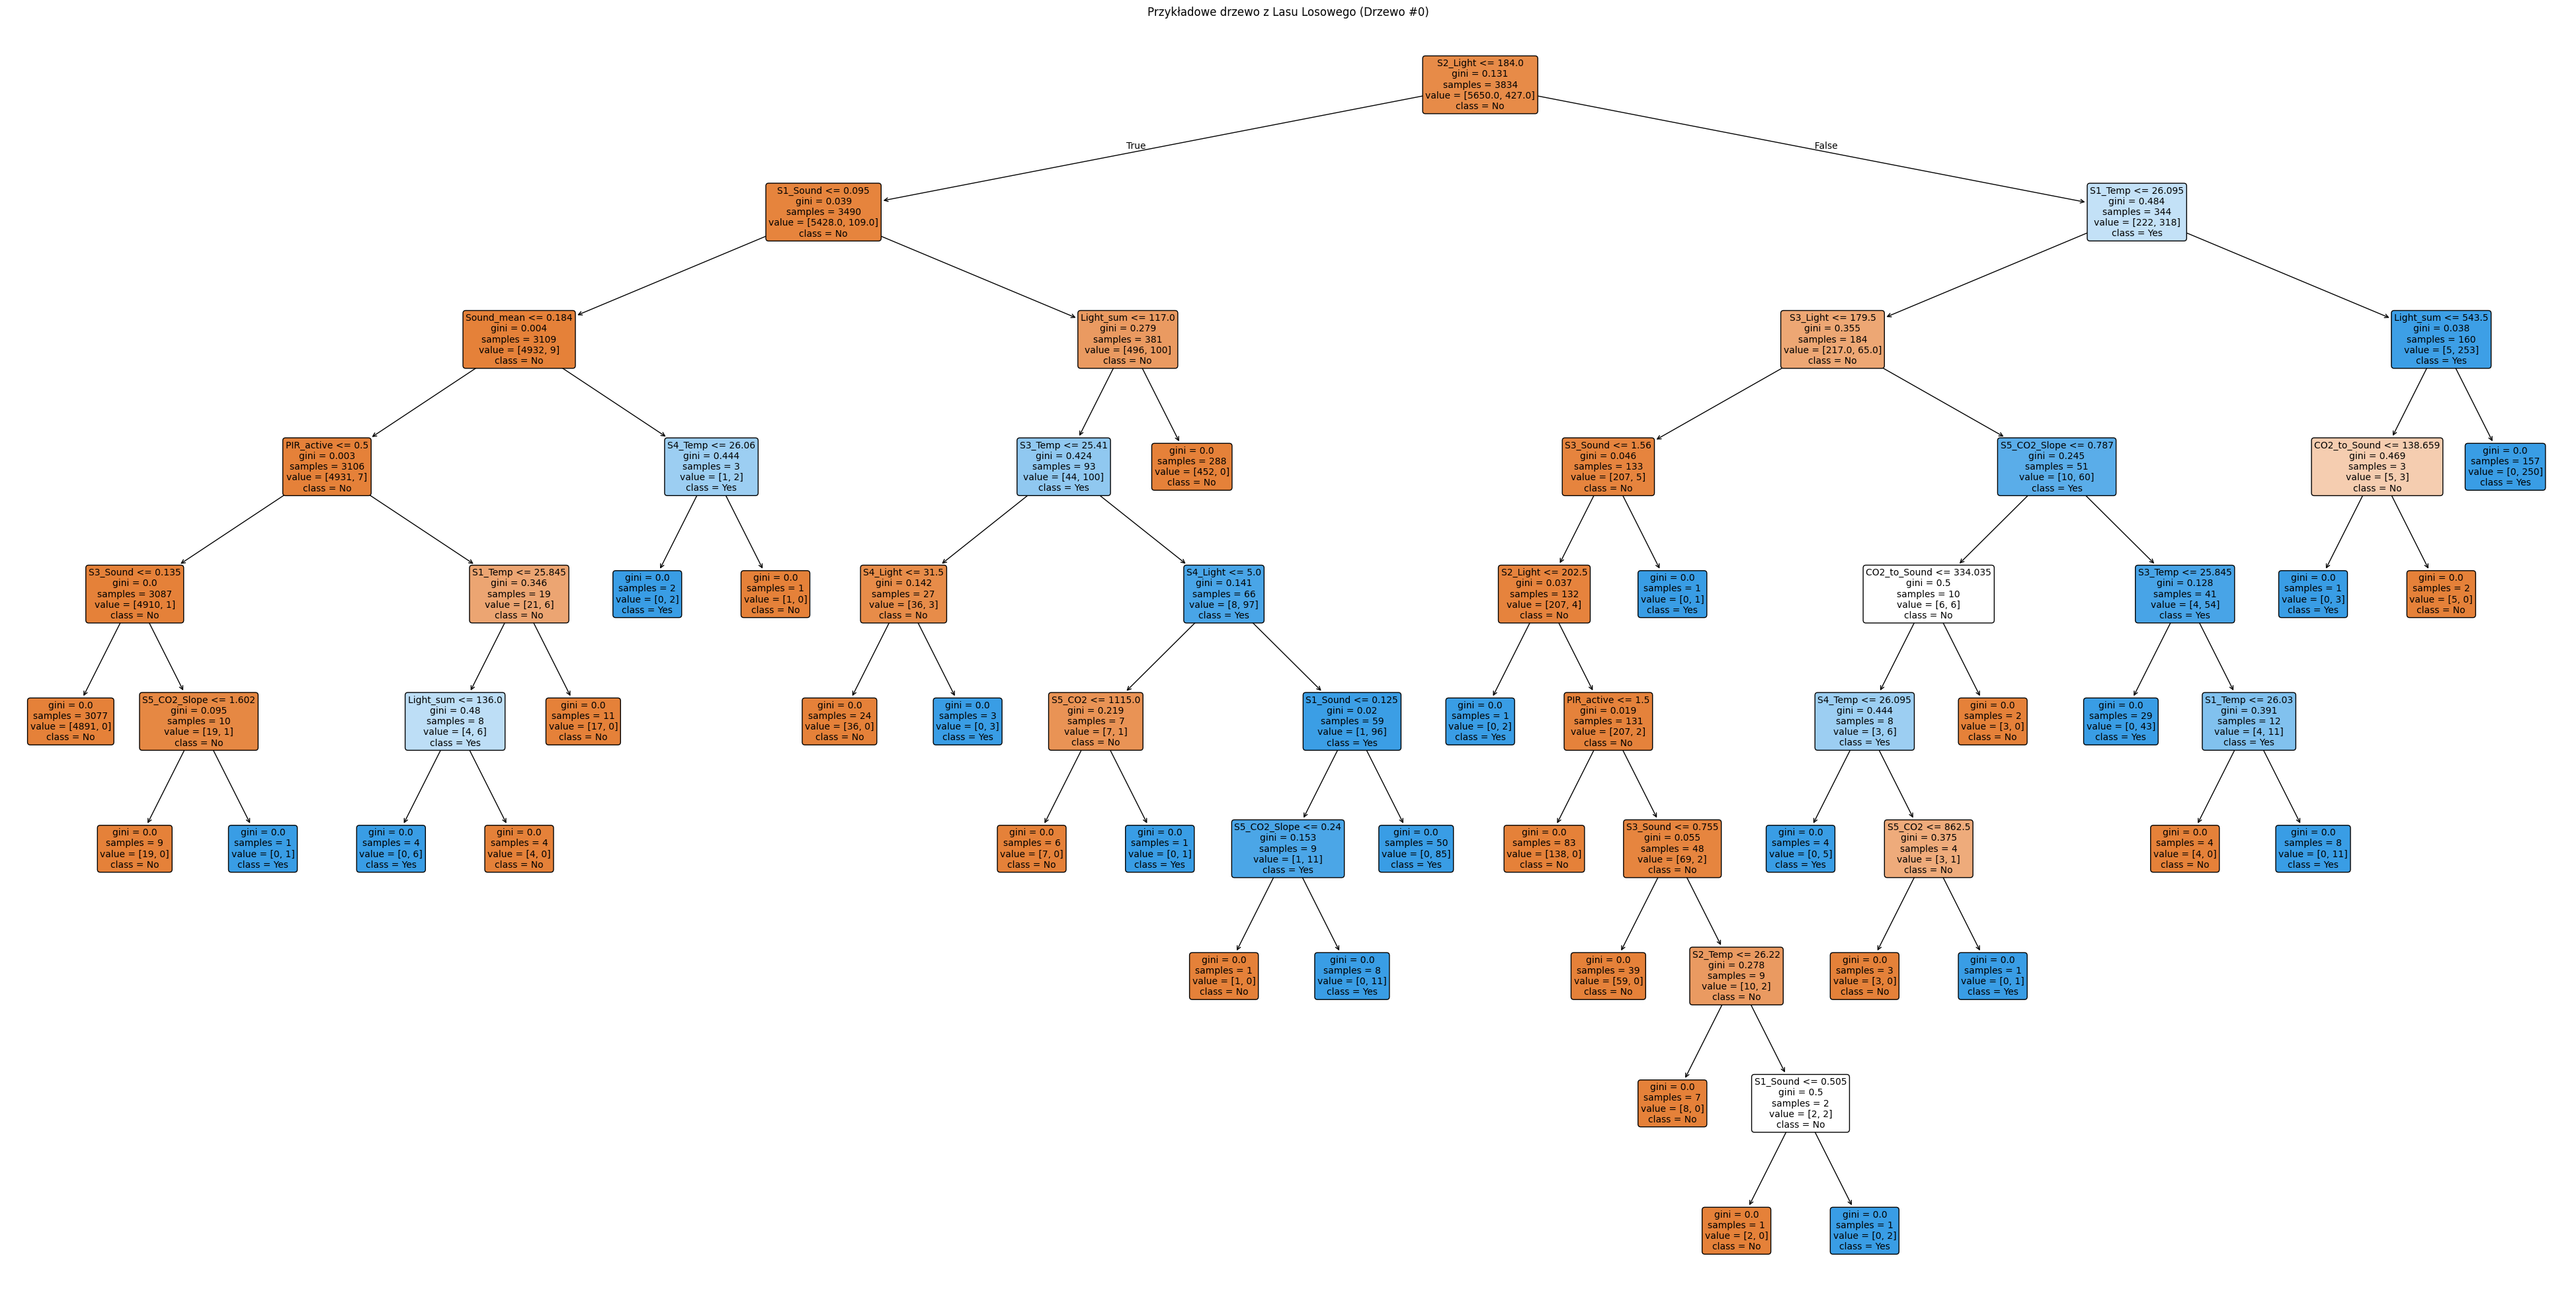

In [223]:
#przykładowe drzewo z lasu

one_tree_from_forest = rf_model.estimators_[0]

plt.figure(figsize=(50, 25))

plot_tree(one_tree_from_forest,
          filled=True,
          feature_names=X_train.columns,
          class_names=['No', 'Yes'],
          rounded=True,
          fontsize=10)

plt.title("Przykładowe drzewo z Lasu Losowego (Drzewo #0)")
plt.show()


### Krzywa ROC (Receiver Operating Characteristic)  
Służy do oceny poprawności klasyfikatora. Przedstawia ona łączny opis jego czułości i specyficzności.
* $TPR=\frac{TP}{TP+FN}$ - czułość
* $FPR=\frac{TN}{TN+FP} $- specyficzność

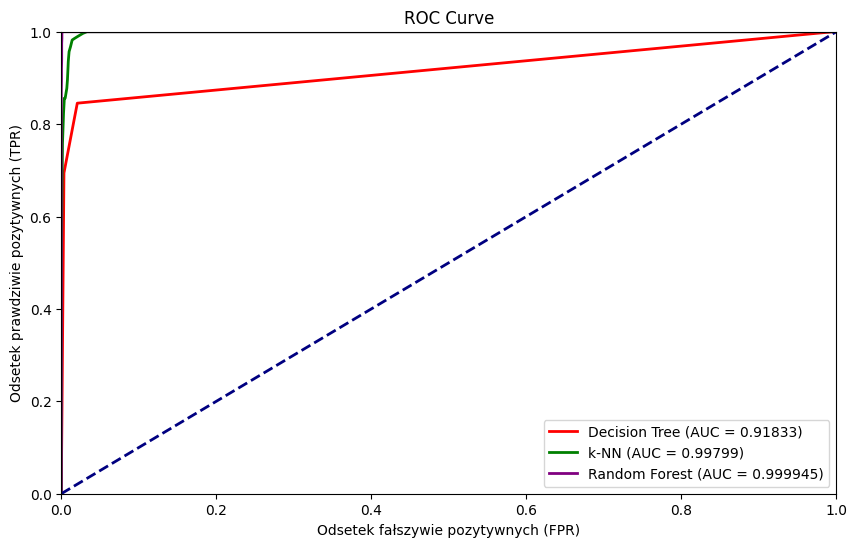

In [224]:
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_proba_dt)
fpr_knn, tpr_knn, _ = roc_curve(y_val, y_proba_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)

plt.figure(figsize=(10, 6))

# Krzywa ROC dla modelu drzewa decyzyjnego
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'Decision Tree (AUC = {auc_dt:.5f})')
# Krzywa ROC dla modelu 1-NN
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'k-NN (AUC = {auc_knn:.5f})')
# Krzywa ROC dla modelu lasu losowego
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest (AUC = {auc_rf:.6f})')

# Linia bazowa
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Ustawienia osi i tytułu
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Odsetek fałszywie pozytywnych (FPR)')
plt.ylabel('Odsetek prawdziwie pozytywnych (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Oto jak interpretować różne części tej krzywej:
* Punkt (0,0): Model klasyfikuje wszystkie próbki jako negatywne, co oznacza, że zarówno $FPR$, jak i $TPR$ wynoszą 0
* Punkt (1,1): Model klasyfikuje wszystkie próbki jako pozytywne, co oznacza, że zarówno $FPR$, jak i $TPR$ wynoszą 1
* Idealny model: Powinien dążyć do lewego górnego rogu (0,1), co oznacza wysoki $TPR$ i niski $FPR$
* Linia losowego klasyfikatora: Linia 45 stopni od (0,0) do (1,1) reprezentuje losowe zgadywanie. Model powyżej tej linii jest lepszy niż losowe zgadywanie, a poniżej - gorszy

**Wnioski z analizy:**

1.  **Las Losowy (Random Forest):**
    * **Wynik:** AUC ≈ **0.9999** (Linia fioletowa).
    * **Interpretacja:** Model jest niemal bezbłędny. Krzywa "przytula się" do lewego górnego rogu, co oznacza, że algorytm perfekcyjnie rozdziela klasy przy zachowaniu niemal zerowego poziomu fałszywych alarmów. Potwierdza to, że metoda zespołowa (wiele drzew) znacząco przewyższa pojedyncze drzewo.

2.  **k-Najbliższych Sąsiadów (k-NN):**
    * **Wynik:** AUC ≈ **0.9980** (Linia zielona).
    * **Interpretacja:** Bardzo wysoka skuteczność. Model świetnie radzi sobie z mapowaniem podobieństw w danych sensorycznych, ustępując Lasowi Losowemu tylko w minimalnym stopniu.

3.  **Drzewo Decyzyjne (Decision Tree):**
    * **Wynik:** AUC ≈ **0.9183** (Linia czerwona).
    * **Interpretacja:** Najsłabszy wynik w zestawieniu. Charakterystyczny "schodkowy" kształt krzywej wynika z prostszej struktury decyzyjnej pojedynczego drzewa. Mimo przyzwoitego wyniku (>0.9), widać wyraźną różnicę klasy w porównaniu do metod bardziej zaawansowanych.